<a href="https://colab.research.google.com/github/Sopralapanca/TwitterDataset-DM-Project/blob/main/DM_predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text
Consider the problem of predicting for each user the label which is a binary variable that indicates if a user is a bot or a genuine user.

The students need to:
1. Define a user profile that enables the classification. Please, reason on the
suitability of the user profile, defined for the clustering analysis. In case this profile is not suitable for the above prediction problem you can also change the indicators.

2. Perform the predictive analysis comparing the performance of different models
discussing the results and discussing the possible preprocessing applied to the
data for managing possible identified problems that can make the prediction hard.

Note that the evaluation should be performed on both training and test sets.


# Downloading data and import libraries

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns 
from os import path

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import statistics

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [ ]:
very_start_time=time.time()

In [ ]:
!pip install gdown
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
file_name = "users_final.parquet.gzip"

In [ ]:
if not path.exists(file_name):
  users_df_id = "1cG6TcjL5DygWGTsThL9CT9XJRqfueg_G"
  !gdown $users_df_id

Downloading...
From: https://drive.google.com/uc?id=1cG6TcjL5DygWGTsThL9CT9XJRqfueg_G
To: /content/users_final.parquet.gzip
100% 1.18M/1.18M [00:00<00:00, 131MB/s]


In [ ]:
df = pd.read_parquet(file_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         11508 non-null  int64         
 1   name                            11508 non-null  string        
 2   lang                            11508 non-null  object        
 3   bot                             11508 non-null  int64         
 4   subscription_date               11508 non-null  datetime64[ns]
 5   statuses_count                  11508 non-null  float64       
 6   number_of_tweets                11508 non-null  int64         
 7   tweets_2019                     11508 non-null  int64         
 8   tweets_2020                     11508 non-null  int64         
 9   likes_sum                       11508 non-null  int64         
 10  likes_mean                      11508 non-null  int64         
 11  li

In [ ]:
# check null values
r = df.isnull().values.any()
assert r == False

# Setup 

First of all we discretize categorical features like lang

In [ ]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

variables = ['lang']
df = discretize_data(df, variables)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         11508 non-null  int64         
 1   name                            11508 non-null  string        
 2   lang                            11508 non-null  object        
 3   bot                             11508 non-null  int64         
 4   subscription_date               11508 non-null  datetime64[ns]
 5   statuses_count                  11508 non-null  float64       
 6   number_of_tweets                11508 non-null  int64         
 7   tweets_2019                     11508 non-null  int64         
 8   tweets_2020                     11508 non-null  int64         
 9   likes_sum                       11508 non-null  int64         
 10  likes_mean                      11508 non-null  int64         
 11  li

We check if the dataset is balanced or not

In [ ]:
print("We have a dataset of", len(df), "users.")
print("The", round(df["bot"].value_counts()[1]/len(df), 4), "% are bots, while the", round(df["bot"].value_counts()[0]/len(df), 4), "% are genunine users.")

We have a dataset of 11508 users.
The 0.5315 % are bots, while the 0.4685 % are genunine users.


Since that, we don't need to use some balancing tecnique.

Then we save bot feature that we use as label for classification and we drop useless feature

In [ ]:
label = df.pop('bot')

df.drop(columns=['name', 'lang', 'subscription_date', 'user_id'], axis=1, inplace=True)

# Scaling the data

In [ ]:
for column in df.columns:
  df[column] = df[column].apply(lambda x: np.log(x+1))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(df.values)
scaled_values = scaler.transform(df.values)

df_scaled = pd.DataFrame(scaled_values, columns=df.columns)

# Utilities

In [ ]:
# Constants 
seed = 42
np.random.seed(seed)

test_size = 0.10  # test set size

# dataframe to plot results
results_df = pd.DataFrame(columns=['model','score','value'])

compute_model_selection = False

In [ ]:
# method to append rows on results_df
# we append the cross validation, f1 score and accuracy for each model we tested

def append_df(results_df, model_name, accuracy_result, f1_result, validation_score):
  new_row = {'model':model_name, 'score':'CROSS-VALIDATION', 'value':validation_score}
  results_df = results_df.append(new_row, ignore_index=True)
  
  new_row = {'model':model_name, 'score':'F1', 'value':f1_result}
  results_df = results_df.append(new_row, ignore_index=True)
  
  new_row = {'model':model_name, 'score':'ACCURACY', 'value':accuracy_result}
  results_df = results_df.append(new_row, ignore_index=True)

  return results_df

## Model Selection utilities

In [ ]:
def plots(random_search, dict_params):
  df = pd.DataFrame(random_search.cv_results_)

  if "param_class_weight" in df.columns: 
    df['param_class_weight'] = df['param_class_weight'].astype("string")

  if "param_hidden_layer_sizes" in df.columns: 
    df['param_hidden_layer_sizes'] = df['param_hidden_layer_sizes'].astype("string")

  if "bootstrap" in df.columns:
    df['bootstrap'] = df['bootstrap'].astype("string")
  
  results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

  
  def pooled_var(stds):
      n = 5 # size of each group
      return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


  fig, axes = plt.subplots(1, len(dict_params), 
                          figsize = (5*len(dict_params), 7),
                          sharey='row')
  if len(dict_params) > 1:
    axes[0].set_ylabel("Score", fontsize=25)
  else:
    axes.set_ylabel("Score", fontsize=25)
  
  lw = 2
  
  for idx, (param_name, param_range) in enumerate(dict_params.items()):
    
      grouped_df = df.groupby(f'param_{param_name}')[results]\
          .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

      previous_group = df.groupby(f'param_{param_name}')[results]
      if len(dict_params) > 1:
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)

        x_values = grouped_df['mean_train_score'].axes[0]

        axes[idx].plot(x_values, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        
        if(param_name=="bootstrap"):
          x_values = x_values.astype("str")
        
        axes[idx].fill_between(x_values, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        
        axes[idx].plot(x_values, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        
        axes[idx].fill_between(x_values, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)
      else:
        axes.set_xlabel(param_name, fontsize=30)
        axes.set_ylim(0.0, 1.1)

        x_values = grouped_df['mean_train_score']

        axes.plot(x_values, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        
        if(param_name=="bootstrap"):
          x_values = x_values.astype("str")
        
        axes.fill_between(x_values, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        
        axes.plot(x_values, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        
        axes.fill_between(x_values, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

  if len(dict_params) > 1:
    handles, labels = axes[0].get_legend_handles_labels()
  else:
    handles, labels = axes.get_legend_handles_labels()
  
  fig.suptitle('Validation curves', fontsize=40)
  fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

  fig.subplots_adjust(bottom=0.25, top=0.85)  
  plt.show()

In [ ]:
# Grid search with Cross Validation
def grid_search(model, dict_params, train_set, train_label, cv=5, verbose=False, plot=False):
    print("[Starting Grid Search]")
    gs = GridSearchCV(model, dict_params, cv=cv, scoring='accuracy', return_train_score=True)
    gs.fit(train_set, train_label)

    if plot:
      plots(gs, dict_params)

    print('Best setting parameters ', gs.best_params_)
    print('Best score', gs.best_score_)
    return gs.best_params_, gs.best_score_


In [ ]:
def random_search(model, dict_params, train_set, train_label, n_iter=30, cv=5, plot=True):
  print("[Starting Random Search]")  
  rs = RandomizedSearchCV(model, param_distributions=dict_params, 
                              n_iter=n_iter, 
                              n_jobs=-1, 
                              cv=cv,
                              scoring=make_scorer(accuracy_score),
                              verbose=3,
                              return_train_score=True)
  
  search = rs.fit(train_set, train_label)
  if plot:
    plots(rs, dict_params)
  
  print('Best setting parameters ', search.best_params_)
  print('Best score', search.best_score_)
  return search.best_params_, search.best_score_

## Evaluation utilities

In [ ]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, 
                      target_names=["Non-Bot", "Bot"]))

In [ ]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support

def evaluation(train_label, train_pred, test_label, test_pred):
  acc_train = metrics.accuracy_score(train_label, train_pred)
  print('Accuracy train set ', acc_train)
  acc_test = metrics.accuracy_score(test_label, test_pred)
  print('Accuracy test set ',acc_test)
  print()
  
  print('Precision train set ', metrics.precision_score(train_label, train_pred, average='weighted'))
  print('Recall train set ', metrics.recall_score(train_label, train_pred, average='weighted'))
  f1_train = metrics.f1_score(train_label, train_pred, average='weighted')
  print('F1 score train set ', f1_train)
  print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred))
  print()
  print('Precision test set ', metrics.precision_score(test_label, test_pred, average='weighted'))
  print('Recall test set ', metrics.recall_score(test_label, test_pred, average='weighted'))
  f1_test = metrics.f1_score(test_label, test_pred, average='weighted')
  print('F1 score test set ', f1_test)
  print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred))
  return acc_train, acc_test, f1_train, f1_test

In [ ]:
from sklearn.model_selection import cross_validate
import statistics 
def CrossValidate(model, train_set, train_label):
  scores = cross_validate(model, train_set, train_label, cv=5, return_train_score= True)
  print('Cross Validation Score: ', statistics.mean(scores['test_score']))
  return statistics.mean(scores['test_score'])

# Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split

# use stratify to keep distribution the same between the splits also we shuffle the data
train_set, test_set, train_label, test_label = train_test_split(df_scaled.values, 
            label, shuffle=True, stratify=label, test_size=test_size)

print("We have a training set of", len(train_set),"elements and a test set of",len(test_set) )

We have a training set of 10357 elements and a test set of 1151


In [ ]:
n_components = len(df_scaled.columns)
n_components

32

# Classification

In [ ]:
# here we store the fitted models
outputs = {}

In [ ]:
# params for model selection for decision tree/random forest models
max_features_list = list(range(2, n_components+1, 2))
min_sample_split_list = list(range(10, 101, 5))
min_sample_leaf_list = list(range(10, 101, 5))
criterion = ["entropy", "gini"]
class_weight = ['balanced', None, {0: 0.3, 1: 0.7}]
max_depth = [10,12,14,16,18,20,22,None]

## Decision Tree

In [ ]:
from sklearn import tree

### Model Selection

In [ ]:
param_dist_dt = {"max_depth": max_depth,
              "max_features": max_features_list,
              "min_samples_split": min_sample_split_list,
              "min_samples_leaf": min_sample_leaf_list,
              "criterion": criterion,
              "class_weight": class_weight}

In [ ]:
if compute_model_selection:
  dec_tree = tree.DecisionTreeClassifier(random_state=seed)

  start_time = time.time()
  dt_best_params, best_score = random_search(model=dec_tree, train_set=train_set, train_label=train_label, 
                                cv=5, dict_params=param_dist_dt,
                                n_iter=100)
  end_time = time.time()
  dt_model_selection_time = end_time-start_time
  print("Model selection time", dt_model_selection_time, "sec")

In [ ]:
if compute_model_selection:
  max_depth_result         = dt_best_params["max_depth"]
  max_features_result      = dt_best_params["max_features"]
  min_samples_split_result = dt_best_params["min_samples_split"]
  min_samples_leaf_result  = dt_best_params["min_samples_leaf"]
  criterion_result         = dt_best_params["criterion"]
  class_weight_result      = dt_best_params["class_weight"]
else:
  max_depth_result         = 14
  max_features_result      = 26
  min_samples_split_result = 50
  min_samples_leaf_result  = 100
  criterion_result         = "gini"
  class_weight_result      = {0: 0.3, 1: 0.7}

### Evaluation

In [ ]:
dec_tree = tree.DecisionTreeClassifier(criterion=criterion_result, max_depth=max_depth_result, 
                                  min_samples_split=min_samples_split_result,
                                  max_features=max_features_result,
                                  min_samples_leaf=min_samples_leaf_result,
                                  class_weight=class_weight_result)

dec_tree = dec_tree.fit(train_set, train_label)

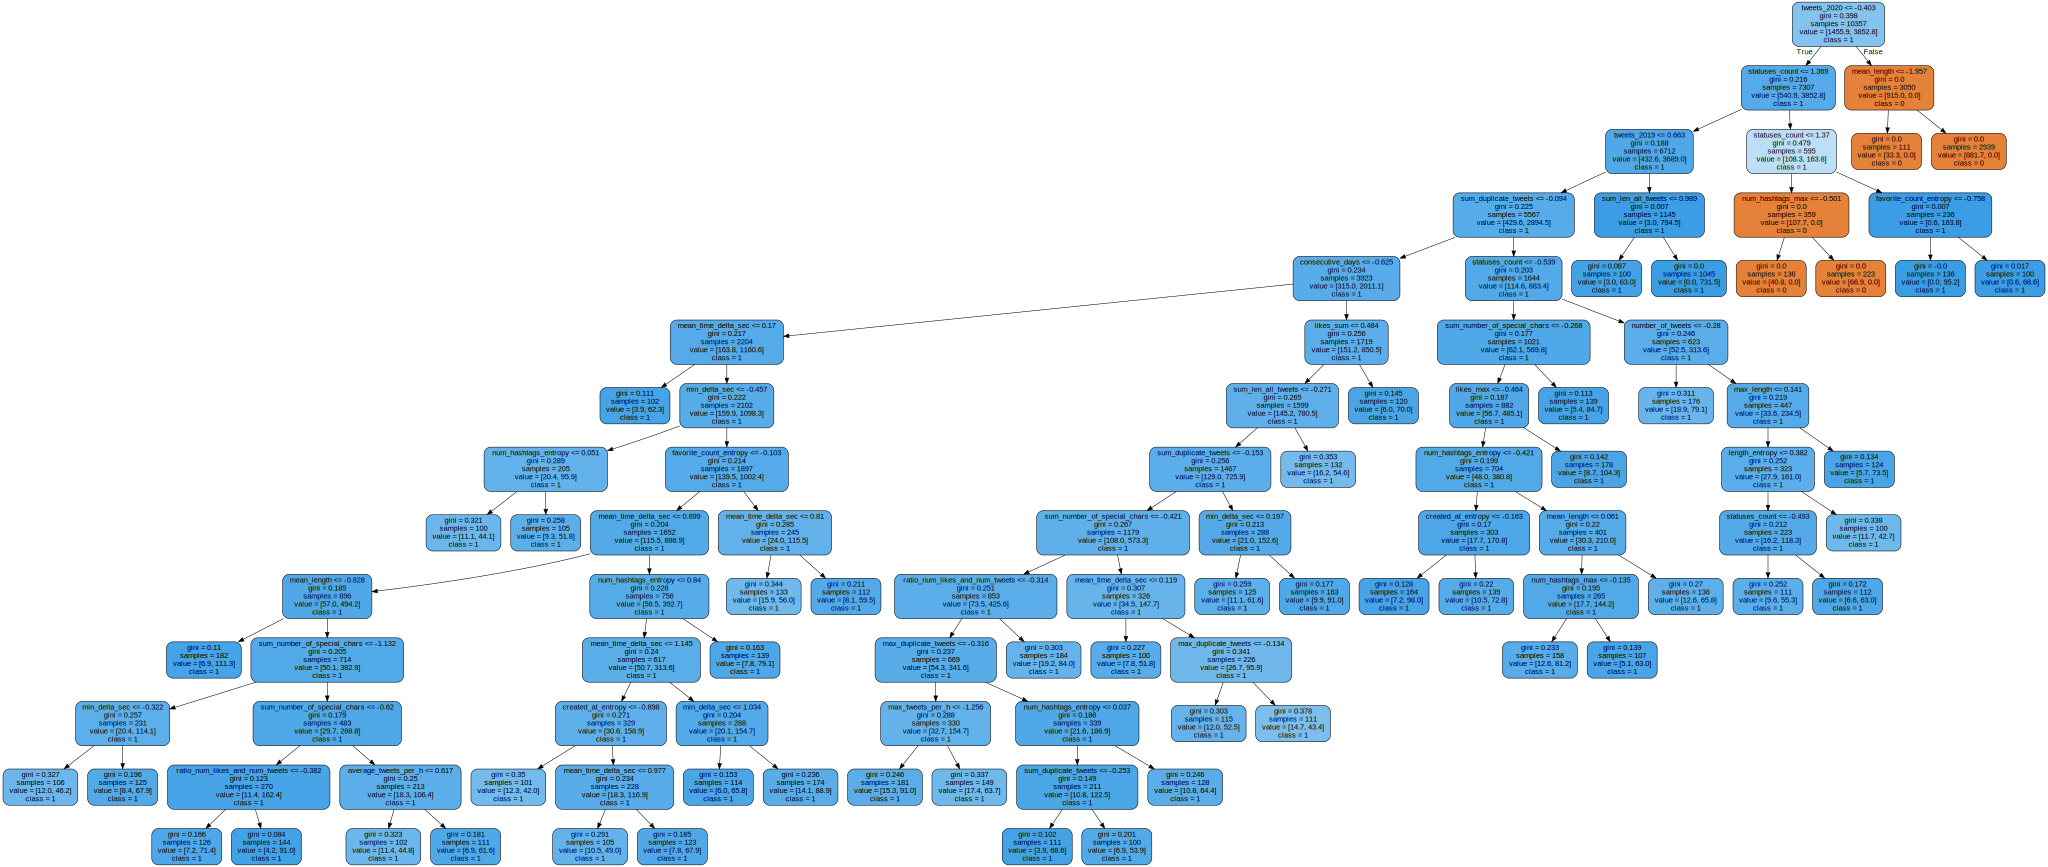

In [ ]:
#visualize the actual decision tree obtained 
import pydotplus
import graphviz

dot_data = tree.export_graphviz(dec_tree, out_file=None, 
                         feature_names=list(df_scaled.columns),  
                         class_names=["0", "1"],  
                         filled=True, rounded=True)
graph = graphviz.Source(dot_data)  

graph

In [ ]:
#predict using the decision tree
train_pred_dt = dec_tree.predict(train_set)
test_pred_dt = dec_tree.predict(test_set)

In [ ]:
acc_dt_train, acc_dt_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_dt, 
                                       test_label=test_label, 
                                       test_pred=test_pred_dt)

if not compute_model_selection:
  best_score = CrossValidate(dec_tree, train_set=train_set, train_label=train_label)
  
results_df = append_df(results_df, "DT", acc_dt_test, f1_test, best_score)

Accuracy train set  0.8605773872743072
Accuracy test set  0.8653344917463076

Precision train set  0.8895535318879948
Recall train set  0.8605773872743072
F1 score train set  0.8564776112166422
Support train set  (array([1.        , 0.79217041]), array([0.70245209, 1.        ]), array([0.82522392, 0.88403469]), array([4853, 5504]))

Precision test set  0.8925485123190876
Recall test set  0.8653344917463076
F1 score test set  0.8615954789411003
Support test set  (array([1.        , 0.79791395]), array([0.71243043, 1.        ]), array([0.83206934, 0.88759971]), array([539, 612]))
Cross Validation Score:  0.860287916046004


In [ ]:
report_scores(train_label, train_pred_dt) #training

              precision    recall  f1-score   support

     Non-Bot       1.00      0.70      0.83      4853
         Bot       0.79      1.00      0.88      5504

    accuracy                           0.86     10357
   macro avg       0.90      0.85      0.85     10357
weighted avg       0.89      0.86      0.86     10357



In [ ]:
report_scores(test_label, test_pred_dt) #test

              precision    recall  f1-score   support

     Non-Bot       1.00      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.87      1151
   macro avg       0.90      0.86      0.86      1151
weighted avg       0.89      0.87      0.86      1151



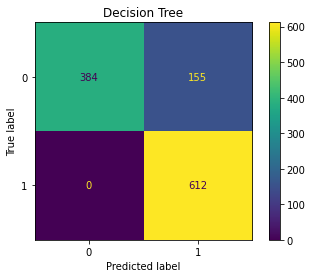

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("Decision Tree")
ConfusionMatrixDisplay.from_estimator(dec_tree, test_set, test_label, ax=ax)

In [ ]:
if not compute_model_selection:
  dt_model_selection_time = None
  dt_best_params = None

key = "dt"
outputs[key] = {}
outputs[key]["model_selection_time"] = dt_model_selection_time
outputs[key]["params"] = dt_best_params
outputs[key]["model"] = dec_tree
outputs[key]["train_acc"] = acc_dt_train
outputs[key]["test_acc"] = acc_dt_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=14,
                       max_features=26, min_samples_leaf=100,
                       min_samples_split=50), 'train_acc': 0.8605773872743072, 'test_acc': 0.8653344917463076}


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Model Selection

In [ ]:
tuned_param_rf = {"max_features": max_features_list,
              "min_samples_split": list(range(50, 100, 5)),
              "min_samples_leaf": list(range(5, 40, 5)),
              "bootstrap": [True, False],
              "criterion": criterion,
              "class_weight": class_weight,
              "n_estimators": list(range(20, 101, 10)),
              }

In [ ]:
if compute_model_selection: 
  rf = RandomForestClassifier(random_state=seed)

  start_time = time.time()

  rf_best_params, best_score = random_search(model=rf, train_set=train_set, train_label=train_label, 
                                cv=5, dict_params=tuned_param_rf, n_iter=10)
  end_time = time.time()
  rf_model_selection_time = end_time-start_time
  print("Model selection time", rf_model_selection_time, "sec")

In [ ]:
if compute_model_selection: 
  n_estimators_result      = rf_best_params["n_estimators"]
  max_features_result      = rf_best_params["max_features"]
  min_samples_split_result = rf_best_params["min_samples_split"]
  min_samples_leaf_result  = rf_best_params["min_samples_leaf"]
  bootstrap_result         = rf_best_params["bootstrap"]
  criterion_result         = rf_best_params["criterion"]
  class_weight_result      = rf_best_params["class_weight"]

else:
  n_estimators_result      = 70
  max_features_result      = 28
  min_samples_split_result = 70
  min_samples_leaf_result  = 30
  bootstrap_result         = True
  criterion_result         = 'gini'
  class_weight_result      = None

In [ ]:
# fit a random forest classifiers using the best parameters found
rf = RandomForestClassifier(n_estimators=n_estimators_result, 
                             criterion=criterion_result,
                             max_features=max_features_result,
                             min_samples_split=min_samples_split_result,
                             min_samples_leaf=min_samples_leaf_result,
                             bootstrap=bootstrap_result,
                             class_weight=class_weight_result)

rf = rf.fit(train_set, train_label)

In [ ]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

### Evaluation


In [ ]:
acc_rf_train, acc_rf_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_rf, 
                                       test_label=test_label, 
                                       test_pred=test_pred_rf)

if not compute_model_selection:
  best_score = CrossValidate(rf, train_set=train_set, train_label=train_label)

results_df = append_df(results_df, "RF", acc_rf_test, f1_test, best_score)

Accuracy train set  0.8605773872743072
Accuracy test set  0.8653344917463076

Precision train set  0.8895535318879948
Recall train set  0.8605773872743072
F1 score train set  0.8564776112166422
Support train set  (array([1.        , 0.79217041]), array([0.70245209, 1.        ]), array([0.82522392, 0.88403469]), array([4853, 5504]))

Precision test set  0.8925485123190876
Recall test set  0.8653344917463076
F1 score test set  0.8615954789411003
Support test set  (array([1.        , 0.79791395]), array([0.71243043, 1.        ]), array([0.83206934, 0.88759971]), array([539, 612]))
Cross Validation Score:  0.8604810594549851


In [ ]:
report_scores(train_label, train_pred_rf)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.70      0.83      4853
         Bot       0.79      1.00      0.88      5504

    accuracy                           0.86     10357
   macro avg       0.90      0.85      0.85     10357
weighted avg       0.89      0.86      0.86     10357



In [ ]:
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.87      1151
   macro avg       0.90      0.86      0.86      1151
weighted avg       0.89      0.87      0.86      1151



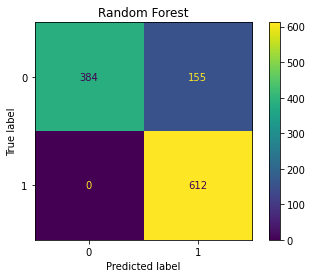

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("Random Forest")
ConfusionMatrixDisplay.from_estimator(rf, test_set, test_label, ax=ax)

In [ ]:
if not compute_model_selection:
  rf_model_selection_time = None
  rf_best_params = None
  
key = "rf"
outputs[key] = {}
outputs[key]["model_selection_time"] = rf_model_selection_time
outputs[key]["params"] = rf_best_params
outputs[key]["model"] = rf
outputs[key]["train_acc"] = acc_rf_train
outputs[key]["test_acc"] = acc_rf_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': RandomForestClassifier(max_features=28, min_samples_leaf=30,
                       min_samples_split=70, n_estimators=70), 'train_acc': 0.8605773872743072, 'test_acc': 0.8653344917463076}


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Model selection (Grid search)



[Starting Grid Search]


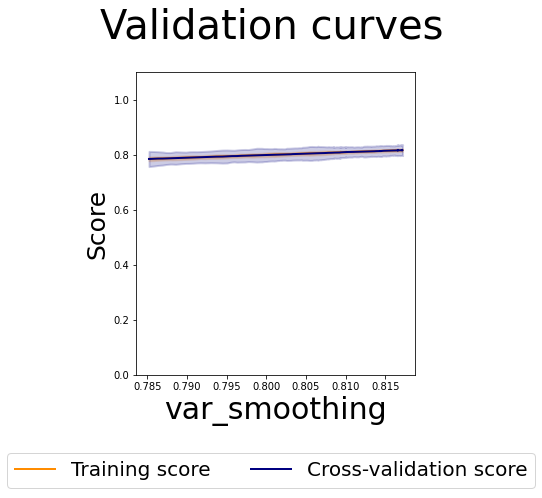

Best setting parameters  {'var_smoothing': 1.6476595119256518e-09}
Best score 0.8169359364192779
Model selection time 14.859802484512329 sec


In [ ]:
gnb = GaussianNB()
param_dist_nb = {'var_smoothing': np.logspace(0,-9, num=250)}

start_time = time.time()
gnb_best_params, best_score = grid_search(model=gnb, train_set=train_set, train_label=train_label, 
                               cv=5, dict_params=param_dist_nb, plot=True)
end_time = time.time()

gnb_model_selection_time = end_time-start_time
print("Model selection time", gnb_model_selection_time, "sec")

best_var_smoothing = gnb_best_params["var_smoothing"]

### Evaluation 

In [ ]:
start_time = time.time()

gnb = GaussianNB(var_smoothing=best_var_smoothing)
train_pred_gnb = gnb.fit(train_set, train_label)

end_time = time.time()
print("Model fitting time",  end_time-start_time, "sec")

Model fitting time 0.01067662239074707 sec


In [ ]:
train_pred_gnb = gnb.predict(train_set)
test_pred_gnb = gnb.predict(test_set)

In [ ]:
acc_gnb_train, acc_gnb_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_gnb, 
                                       test_label=test_label, 
                                       test_pred=test_pred_gnb)

results_df = append_df(results_df, "NB", acc_gnb_test, f1_test, best_score)

Accuracy train set  0.8170319590615043
Accuracy test set  0.8218940052128584

Precision train set  0.8503620292965769
Recall train set  0.8170319590615043
F1 score train set  0.8102270929300969
Support train set  (array([0.96161049, 0.75227177]), array([0.63486503, 0.97765262]), array([0.76480079, 0.85028048]), array([4853, 5504]))

Precision test set  0.8515111970193817
Recall test set  0.8218940052128584
F1 score test set  0.8158986521665507
Support test set  (array([0.95628415, 0.75923567]), array([0.64935065, 0.97385621]), array([0.77348066, 0.85325698]), array([539, 612]))


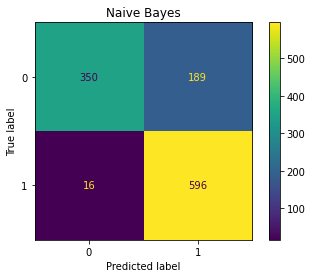

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("Naive Bayes")
ConfusionMatrixDisplay.from_estimator(gnb, test_set, test_label, ax=ax)

In [ ]:
report_scores(train_label, train_pred_gnb)

              precision    recall  f1-score   support

     Non-Bot       0.96      0.63      0.76      4853
         Bot       0.75      0.98      0.85      5504

    accuracy                           0.82     10357
   macro avg       0.86      0.81      0.81     10357
weighted avg       0.85      0.82      0.81     10357



In [ ]:
report_scores(test_label, test_pred_gnb)

              precision    recall  f1-score   support

     Non-Bot       0.96      0.65      0.77       539
         Bot       0.76      0.97      0.85       612

    accuracy                           0.82      1151
   macro avg       0.86      0.81      0.81      1151
weighted avg       0.85      0.82      0.82      1151



In [ ]:
# Saving results
key = "nb"
outputs[key] = {}
outputs[key]["model_selection_time"] = gnb_model_selection_time
outputs[key]["params"] = gnb_best_params
outputs[key]["model"] = gnb
outputs[key]["train_acc"] = acc_gnb_train
outputs[key]["test_acc"] = acc_gnb_test

print(outputs[key])

{'model_selection_time': 14.859802484512329, 'params': {'var_smoothing': 1.6476595119256518e-09}, 'model': GaussianNB(var_smoothing=1.6476595119256518e-09), 'train_acc': 0.8170319590615043, 'test_acc': 0.8218940052128584}


## Neural Network (Sklearn)

### Model Selection

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
layers=[2, 3]
units_per_layer =[64, 32, 16]
hidden_layer_sizes = []

for units in units_per_layer:
  for layer in layers[1:]:
    tmp=[]
    for i in range(layer):
      tmp.append(units)
    hidden_layer_sizes.append(tmp)

for layer in layers:
  tmp=[]
  for i in range(layer):
    tmp.append(units_per_layer[i])
  hidden_layer_sizes.append(tmp)


hidden_layer_sizes

[[64, 64, 64], [32, 32, 32], [16, 16, 16], [64, 32], [64, 32, 16]]

In [ ]:
param_dist = {
    "hidden_layer_sizes": hidden_layer_sizes,
    "learning_rate_init": [0.1, 0.01, 0.001],
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.1,0.01,0.001],
    "learning_rate": ["constant", "invscaling", "adaptive"],
}
max_iter = 500
early_stopping = True
validation_fraction=0.1

if compute_model_selection: 
  nn = MLPClassifier(max_iter=max_iter, 
                    validation_fraction=validation_fraction,
                    early_stopping=early_stopping, random_state=seed)

  start_time = time.time()
  nn_best_params, best_score = random_search(model=nn, train_set=train_set, train_label=train_label, 
                                cv=5, dict_params=param_dist, plot=True, n_iter=20)
  end_time = time.time()
  nn_model_selection_time = end_time-start_time
  print("Model selection time", nn_model_selection_time, "sec")


In [ ]:
if compute_model_selection: 
  hidden_layer_sizes_results = nn_best_params["hidden_layer_sizes"]
  learning_rate_init_results = nn_best_params["learning_rate_init"]
  learning_rate_results      = nn_best_params["learning_rate"]
  solver_results             = nn_best_params["solver"]
  alpha_results              = nn_best_params["alpha"]
  activation_results         = nn_best_params["activation"]
else:
  hidden_layer_sizes_results = [32, 32, 32]
  learning_rate_init_results = 0.01
  learning_rate_results      = 'adaptive'
  solver_results             = 'adam'
  alpha_results              =  0.1
  activation_results         = 'tanh'

In [ ]:
nn = MLPClassifier(max_iter=max_iter, 
                   validation_fraction=validation_fraction, solver=solver_results,
                   early_stopping=early_stopping,
                   hidden_layer_sizes=hidden_layer_sizes_results, learning_rate_init=learning_rate_init_results,
                   learning_rate=learning_rate_results, alpha=alpha_results, activation=activation_results)

nn = nn.fit(train_set, train_label)

In [ ]:
train_pred_nn = nn.predict(train_set)
test_pred_nn  = nn.predict(test_set)

### Evaluation

In [ ]:
acc_nn_train, acc_nn_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_nn, 
                                       test_label=test_label, 
                                       test_pred=test_pred_nn)
if not compute_model_selection:
  best_score = CrossValidate(nn, train_set=train_set, train_label=train_label)

results_df = append_df(results_df, "NN", acc_nn_test, f1_test, best_score)

Accuracy train set  0.8603842811624988
Accuracy test set  0.8627280625543006

Precision train set  0.8888784315679732
Recall train set  0.8603842811624988
F1 score train set  0.8563283665388087
Support train set  (array([0.9982451 , 0.79244739]), array([0.70327632, 0.99890988]), array([0.82519342, 0.88378074]), array([4853, 5504]))

Precision test set  0.8884964394104563
Recall test set  0.8627280625543006
F1 score test set  0.859043563504999
Support test set  (array([0.99224806, 0.79712042]), array([0.71243043, 0.99509804]), array([0.82937365, 0.88517442]), array([539, 612]))
Cross Validation Score:  0.8588396667344036


In [ ]:
report_scores(train_label, train_pred_nn)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.70      0.83      4853
         Bot       0.79      1.00      0.88      5504

    accuracy                           0.86     10357
   macro avg       0.90      0.85      0.85     10357
weighted avg       0.89      0.86      0.86     10357



In [ ]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

     Non-Bot       0.99      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.86      1151
   macro avg       0.89      0.85      0.86      1151
weighted avg       0.89      0.86      0.86      1151



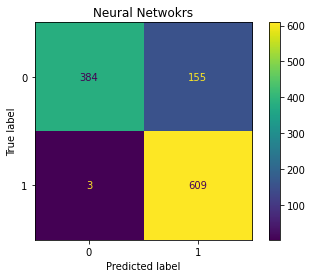

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("Neural Netwokrs")
ConfusionMatrixDisplay.from_estimator(nn, test_set, test_label, ax=ax)

In [ ]:
# Saving results
if not compute_model_selection:
  nn_model_selection_time = None
  nn_best_params = None
  
key = "nn"
outputs[key] = {}
outputs[key]["model_selection_time"] = nn_model_selection_time
outputs[key]["params"] = nn_best_params
outputs[key]["model"] = nn
outputs[key]["train_acc"] = acc_nn_train
outputs[key]["test_acc"] = acc_nn_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=[32, 32, 32], learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=500), 'train_acc': 0.8603842811624988, 'test_acc': 0.8627280625543006}


## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

### Model Selection

In [ ]:
tuned_params_svc = {
    'kernel': ["linear", "rbf", "sigmoid"], 
    'gamma': [0.001,0.0001],
    'C': [5,10,15,20]}

In [ ]:
if compute_model_selection:
  svc = SVC(random_state=seed, cache_size=1000)

  start_time = time.time()
  svc_best_params, best_score = random_search(model=svc, train_set=train_set, train_label=train_label,
                                  dict_params=tuned_params_svc, n_iter=10, plot=True)
  end_time = time.time()
  svc_model_selection_time = end_time-start_time
  print("Model selection time", svc_best_params, "sec")

In [ ]:
if compute_model_selection:
  C       = svc_best_params["C"]
  kernel  = svc_best_params["kernel"]
  gamma   = svc_best_params["gamma"]
else: 
  C       = 20
  kernel  = 'rbf'
  gamma   = 0.001

In [ ]:
svc = SVC(C=C,
          kernel=kernel,
          gamma=gamma,
          cache_size=1000
          )

svc = svc.fit(train_set, train_label)

In [ ]:
train_pred_svc  = svc.predict(train_set)
test_pred_svc   = svc.predict(test_set)

### Evaluation

In [ ]:
acc_svc_train, acc_svc_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_svc, 
                                       test_label=test_label, 
                                       test_pred=test_pred_svc)
if not compute_model_selection:
  best_score = CrossValidate(svc, train_set=train_set, train_label=train_label)

results_df = append_df(results_df, "SVC", acc_svc_test, f1_test, best_score)

Accuracy train set  0.8599015158829777
Accuracy test set  0.8653344917463076

Precision train set  0.8890367133243542
Recall train set  0.8599015158829777
F1 score train set  0.8557568896895
Support train set  (array([0.99970623, 0.79145693]), array([0.70121574, 0.99981831]), array([0.82427032, 0.88351931]), array([4853, 5504]))

Precision test set  0.8925485123190876
Recall test set  0.8653344917463076
F1 score test set  0.8615954789411003
Support test set  (array([1.        , 0.79791395]), array([0.71243043, 1.        ]), array([0.83206934, 0.88759971]), array([539, 612]))
Cross Validation Score:  0.8597087188588879


In [ ]:
report_scores(train_label, train_pred_svc)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.70      0.82      4853
         Bot       0.79      1.00      0.88      5504

    accuracy                           0.86     10357
   macro avg       0.90      0.85      0.85     10357
weighted avg       0.89      0.86      0.86     10357



In [ ]:
report_scores(test_label, test_pred_svc)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.87      1151
   macro avg       0.90      0.86      0.86      1151
weighted avg       0.89      0.87      0.86      1151



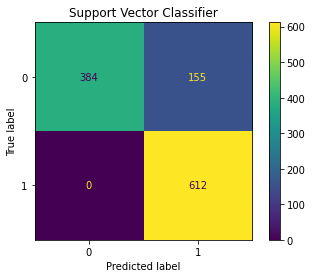

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("Support Vector Classifier")
ConfusionMatrixDisplay.from_estimator(svc, test_set, test_label, ax=ax)

In [ ]:
# Saving results
if not compute_model_selection:
  svc_model_selection_time = None
  svc_best_params = None
  
# Saving results
key = "svc"
outputs[key] = {}
outputs[key]["model_selection_time"] = svc_model_selection_time
outputs[key]["params"] = svc_best_params
outputs[key]["model"] = svc
outputs[key]["train_acc"] = acc_svc_train
outputs[key]["test_acc"] = acc_svc_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': SVC(C=20, cache_size=1000, gamma=0.001), 'train_acc': 0.8599015158829777, 'test_acc': 0.8653344917463076}


## Gradient Boosting Classifier + RandomForest

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

### Model Selection

In [ ]:
# first we define parameters we want to try to perform a model selection
param_dist_gbc = {"loss": ["deviance", "exponential"],
                  "n_estimators": [10, 25, 50],
                  "learning_rate": [0.5, 1.0, 1.5],
                  "min_samples_split": min_sample_split_list,
                  "min_samples_leaf": min_sample_leaf_list,
                  "max_depth": max_depth,
                  "max_features": max_features_list
              }

if compute_model_selection:
  gbc = GradientBoostingClassifier(init=rf, n_iter_no_change=5, random_state=seed)

  start_time = time.time()
  gbc_best_params, best_score = random_search(model=gbc, train_set = train_set, train_label=train_label, 
                                  dict_params=param_dist_gbc, n_iter=10, plot=True)
  end_time = time.time()
  gbc_model_selection_time = end_time-start_time
  print("Model selection time", gbc_best_params, "sec")



In [ ]:
if compute_model_selection:
  loss_result              = gbc_best_params["loss"]
  n_estimators_result      = gbc_best_params["n_estimators"]
  learning_rate_result     = gbc_best_params["learning_rate"]
  min_samples_split_result = gbc_best_params["min_samples_split"]
  min_samples_leaf_result  = gbc_best_params["min_samples_leaf"]
  max_depth_result         = gbc_best_params["max_depth"]
  max_features_result      = gbc_best_params["max_features"]
else:
  loss_result              = 'deviance'
  n_estimators_result      = 25
  learning_rate_result     = 0.5
  min_samples_split_result = 95
  min_samples_leaf_result  = 85
  max_depth_result         = 18
  max_features_result      = 28

In [ ]:
gbc = GradientBoostingClassifier(init=rf, n_iter_no_change=5,
                                 loss=loss_result, n_estimators=n_estimators_result,
                                 learning_rate = learning_rate_result, min_samples_leaf=min_samples_leaf_result,
                                 min_samples_split=min_samples_split_result, max_depth=max_depth_result, max_features=max_features_result)


gbc = gbc.fit(train_set, train_label)

In [ ]:
train_pred_gbc  = gbc.predict(train_set)
test_pred_gbc   = gbc.predict(test_set)

### Evaluation

In [ ]:
acc_gbc_train, acc_gbc_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_gbc, 
                                       test_label=test_label, 
                                       test_pred=test_pred_gbc)
if not compute_model_selection:
  best_score = CrossValidate(gbc, train_set=train_set, train_label=train_label)

results_df = append_df(results_df, "GBC", acc_gbc_test, f1_test, best_score)

Accuracy train set  0.8776672781693541
Accuracy test set  0.8566463944396178

Precision train set  0.8973591061585122
Recall train set  0.8776672781693541
F1 score train set  0.8751055530505423
Support train set  (array([0.98882225, 0.81671401]), array([0.74737276, 0.99255087]), array([0.85130853, 0.89608792]), array([4853, 5504]))

Precision test set  0.8778437411894277
Recall test set  0.8566463944396178
F1 score test set  0.8532644282282433
Support test set  (array([0.96984925, 0.79681275]), array([0.716141  , 0.98039216]), array([0.82390608, 0.87912088]), array([539, 612]))
Cross Validation Score:  0.8516950850968233


In [ ]:
report_scores(train_label, train_pred_gbc)

              precision    recall  f1-score   support

     Non-Bot       0.99      0.75      0.85      4853
         Bot       0.82      0.99      0.90      5504

    accuracy                           0.88     10357
   macro avg       0.90      0.87      0.87     10357
weighted avg       0.90      0.88      0.88     10357



In [ ]:
report_scores(test_label, test_pred_gbc)

              precision    recall  f1-score   support

     Non-Bot       0.97      0.72      0.82       539
         Bot       0.80      0.98      0.88       612

    accuracy                           0.86      1151
   macro avg       0.88      0.85      0.85      1151
weighted avg       0.88      0.86      0.85      1151



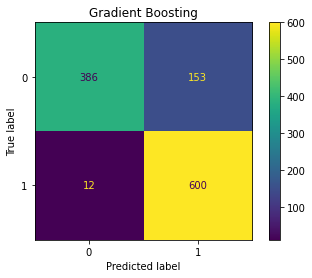

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("Gradient Boosting")
ConfusionMatrixDisplay.from_estimator(gbc, test_set, test_label, ax=ax)

In [ ]:
# Saving results
if not compute_model_selection:
  svc_model_selection_time = None
  svc_best_params = None

key = "gbc"
outputs[key] = {}
outputs[key]["model_selection_time"] = svc_model_selection_time
outputs[key]["params"] = svc_best_params
outputs[key]["model"] = gbc
outputs[key]["train_acc"] = acc_gbc_train
outputs[key]["test_acc"] = acc_gbc_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': GradientBoostingClassifier(init=RandomForestClassifier(max_features=28,
                                                       min_samples_leaf=30,
                                                       min_samples_split=70,
                                                       n_estimators=70),
                           learning_rate=0.5, max_depth=18, max_features=28,
                           min_samples_leaf=85, min_samples_split=95,
                           n_estimators=25, n_iter_no_change=5), 'train_acc': 0.8776672781693541, 'test_acc': 0.8566463944396178}


## BaggingClassifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

#### Model Selection

In [ ]:
param_dist_bagging = {"n_estimators": list(range(20, 101, 10)),
                      "max_features": max_features_list,
                      "bootstrap": [True, False]
                      }

if compute_model_selection:
  bagging = BaggingClassifier(random_state=seed)

  start_time = time.time()
  bagging_best_params, best_score = random_search(model=bagging, train_set=train_set,train_label=train_label, 
                                      n_iter=10, dict_params=param_dist_bagging)
  end_time = time.time()

  bagging_model_selection_time = end_time-start_time
  print("Model selection time", bagging_model_selection_time, "sec")

In [ ]:
if compute_model_selection:
  n_estimators_result = bagging_best_params["n_estimators"]
  max_features_result = bagging_best_params["max_features"]
  bootstrap_result = bagging_best_params["bootstrap"]
else:
  n_estimators_result = 80
  max_features_result = 22
  bootstrap_result = True

In [ ]:
bagging = BaggingClassifier(n_estimators = n_estimators_result,
                            max_features = max_features_result,
                            bootstrap  = bootstrap_result)
bagging = bagging.fit(train_set, train_label)

#### Evaluation

In [ ]:
train_pred_bagging  = bagging.predict(train_set)
test_pred_bagging   = bagging.predict(test_set)

In [ ]:
acc_bagging_train, acc_bagging_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_bagging, 
                                       test_label=test_label, 
                                       test_pred=test_pred_bagging)
if not compute_model_selection:
  best_score = CrossValidate(bagging, train_set=train_set, train_label=train_label)
results_df = append_df(results_df, "BAGGING", acc_bagging_test, f1_test, best_score)

Accuracy train set  0.9999034469440958
Accuracy test set  0.8601216333622936

Precision train set  0.9999034668355372
Recall train set  0.9999034469440958
F1 score train set  0.9999034475314841
Support train set  (array([0.99979398, 1.        ]), array([1.        , 0.99981831]), array([0.99989698, 0.99990915]), array([4853, 5504]))

Precision test set  0.8830254652327287
Recall test set  0.8601216333622936
F1 score test set  0.8566599291513685
Support test set  (array([0.97969543, 0.79788639]), array([0.716141 , 0.9869281]), array([0.82743837, 0.88239591]), array([539, 612]))
Cross Validation Score:  0.8509220919892093


In [ ]:
report_scores(train_label, train_pred_bagging)

              precision    recall  f1-score   support

     Non-Bot       1.00      1.00      1.00      4853
         Bot       1.00      1.00      1.00      5504

    accuracy                           1.00     10357
   macro avg       1.00      1.00      1.00     10357
weighted avg       1.00      1.00      1.00     10357



In [ ]:
report_scores(test_label, test_pred_bagging)

              precision    recall  f1-score   support

     Non-Bot       0.98      0.72      0.83       539
         Bot       0.80      0.99      0.88       612

    accuracy                           0.86      1151
   macro avg       0.89      0.85      0.85      1151
weighted avg       0.88      0.86      0.86      1151



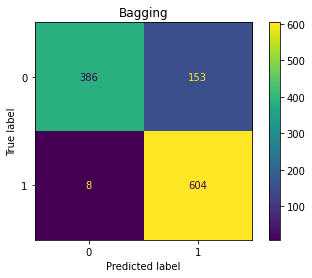

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("Bagging")
ConfusionMatrixDisplay.from_estimator(bagging, test_set, test_label, ax=ax)

In [ ]:
if not compute_model_selection:
  bagging_model_selection_time = None
  bagging_best_params = None

key = "bagging"
outputs[key] = {}
outputs[key]["model_selection_time"] = bagging_model_selection_time
outputs[key]["params"] = bagging_best_params
outputs[key]["model"] = bagging
outputs[key]["train_acc"] = acc_bagging_train
outputs[key]["test_acc"] = acc_bagging_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': BaggingClassifier(max_features=22, n_estimators=80), 'train_acc': 0.9999034469440958, 'test_acc': 0.8601216333622936}


## AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
param_dist = {
    "n_estimators": [25, 50],
    "learning_rate": [0.001, 0.01, 0.1]
}

###AdaBoost + DecisionTree

In [ ]:
if compute_model_selection:
  abc = AdaBoostClassifier(base_estimator=dec_tree,random_state=seed)

  start_time = time.time()
  abc_best_params, best_score = random_search(model=abc, train_set = train_set, train_label = train_label, dict_params=param_dist)
  end_time = time.time()
  abc_model_selection_time = end_time-start_time
  print("Model selection time", abc_model_selection_time, "sec")


In [ ]:
if compute_model_selection:
  n_estimators_result         = abc_best_params["n_estimators"]
  learning_rate_result        = abc_best_params["learning_rate"]
else:
  n_estimators_result         = 50
  learning_rate_result        = 0.001

In [ ]:
abc = AdaBoostClassifier(base_estimator=dec_tree,n_estimators=n_estimators_result, 
                         learning_rate=learning_rate_result)
abc.fit(train_set, train_label)

train_pred_abc = abc.predict(train_set)
test_pred_abc = abc.predict(test_set)

In [ ]:
report_scores(train_label, train_pred_abc)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.70      0.83      4853
         Bot       0.79      1.00      0.88      5504

    accuracy                           0.86     10357
   macro avg       0.90      0.85      0.85     10357
weighted avg       0.89      0.86      0.86     10357



In [ ]:
report_scores(test_label, test_pred_abc)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.87      1151
   macro avg       0.90      0.86      0.86      1151
weighted avg       0.89      0.87      0.86      1151



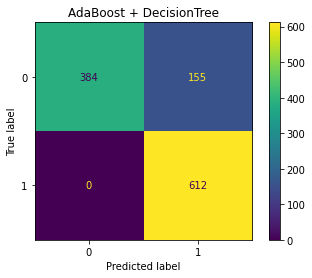

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("AdaBoost + DecisionTree")
ConfusionMatrixDisplay.from_estimator(abc, test_set, test_label, ax=ax)

In [ ]:
acc_abc_train, acc_abc_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_abc, 
                                       test_label=test_label, 
                                       test_pred=test_pred_abc)
if not compute_model_selection:
  best_score = CrossValidate(abc, train_set=train_set, train_label=train_label)
  
results_df = append_df(results_df, "ABC+DT", acc_abc_test, f1_test, best_score)

Accuracy train set  0.8606739403302115
Accuracy test set  0.8653344917463076

Precision train set  0.8896141309309751
Recall train set  0.8606739403302115
F1 score train set  0.856581961507777
Support train set  (array([1.        , 0.79228444]), array([0.70265815, 1.        ]), array([0.82536609, 0.88410569]), array([4853, 5504]))

Precision test set  0.8925485123190876
Recall test set  0.8653344917463076
F1 score test set  0.8615954789411003
Support test set  (array([1.        , 0.79791395]), array([0.71243043, 1.        ]), array([0.83206934, 0.88759971]), array([539, 612]))
Cross Validation Score:  0.8603844877504945


In [ ]:
# Saving results
if not compute_model_selection:
  abc_model_selection_time = None
  abc_best_params = None

key = "AdaBoost+DT"
outputs[key] = {}
outputs[key]["model_selection_time"] = abc_model_selection_time
outputs[key]["params"] = abc_best_params
outputs[key]["model"] = abc
outputs[key]["train_acc"] = acc_abc_train
outputs[key]["test_acc"] = acc_abc_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.3,
                                                                       1: 0.7},
                                                         max_depth=14,
                                                         max_features=26,
                                                         min_samples_leaf=100,
                                                         min_samples_split=50),
                   learning_rate=0.001), 'train_acc': 0.8606739403302115, 'test_acc': 0.8653344917463076}


###AdaBoost + Random Forest

In [ ]:
if compute_model_selection:
  abc = AdaBoostClassifier(base_estimator=rf,random_state=seed)

  start_time = time.time()
  abc_best_params, best_score = random_search(model=abc, train_label=train_label, train_set=train_set, 
                                  n_iter=10, 
                                  dict_params=param_dist)
  end_time = time.time()
  abc_model_selection_time = end_time-start_time
  print("Model selection time", abc_model_selection_time, "sec")

In [ ]:
if compute_model_selection:
  n_estimators_result         = abc_best_params["n_estimators"]
  learning_rate_result        = abc_best_params["learning_rate"]
else:
  n_estimators_result         = 50
  learning_rate_result        = 0.01

In [ ]:
abc = AdaBoostClassifier(base_estimator=rf,n_estimators=n_estimators_result, 
                         learning_rate=learning_rate_result)
abc.fit(train_set, train_label)

train_pred_abc = abc.predict(train_set)
test_pred_abc = abc.predict(test_set)

In [ ]:
report_scores(train_label, train_pred_abc)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.70      0.83      4853
         Bot       0.79      1.00      0.88      5504

    accuracy                           0.86     10357
   macro avg       0.90      0.85      0.85     10357
weighted avg       0.89      0.86      0.86     10357



In [ ]:
report_scores(test_label, test_pred_abc)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.87      1151
   macro avg       0.90      0.86      0.86      1151
weighted avg       0.89      0.87      0.86      1151



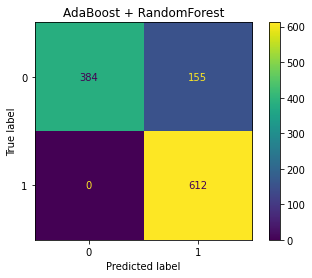

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("AdaBoost + RandomForest")
ConfusionMatrixDisplay.from_estimator(abc, test_set, test_label, ax=ax)

In [ ]:
acc_abc_train, acc_abc_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_abc, 
                                       test_label=test_label, 
                                       test_pred=test_pred_abc)
if not compute_model_selection:
  best_score = CrossValidate(abc, train_set=train_set, train_label=train_label)

results_df = append_df(results_df, "ABC+RF", acc_abc_test, f1_test, best_score)

Accuracy train set  0.8605773872743072
Accuracy test set  0.8653344917463076

Precision train set  0.8895535318879948
Recall train set  0.8605773872743072
F1 score train set  0.8564776112166422
Support train set  (array([1.        , 0.79217041]), array([0.70245209, 1.        ]), array([0.82522392, 0.88403469]), array([4853, 5504]))

Precision test set  0.8925485123190876
Recall test set  0.8653344917463076
F1 score test set  0.8615954789411003
Support test set  (array([1.        , 0.79791395]), array([0.71243043, 1.        ]), array([0.83206934, 0.88759971]), array([539, 612]))
Cross Validation Score:  0.8605776311594757


In [ ]:
# Saving results
key = "AdaBoost+RF"
outputs[key] = {}
outputs[key]["model_selection_time"] = abc_model_selection_time
outputs[key]["params"] = abc_best_params
outputs[key]["model"] = abc
outputs[key]["train_acc"] = acc_abc_train
outputs[key]["test_acc"] = acc_abc_test

print(outputs[key])

{'model_selection_time': None, 'params': None, 'model': AdaBoostClassifier(base_estimator=RandomForestClassifier(max_features=28,
                                                         min_samples_leaf=30,
                                                         min_samples_split=70,
                                                         n_estimators=70),
                   learning_rate=0.01), 'train_acc': 0.8605773872743072, 'test_acc': 0.8653344917463076}


## K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### Model Selection

In [ ]:
knn_model_selection_time = 0
knn_best_params = None

if compute_model_selection:
  param_dist = {"n_neighbors": [i for i in range(5,101,5)],
              "weights" : ['uniform', 'distance'],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [i for i in range(10, 60, 5)],
              'p': [1, 2],
              'metric': ['minkowski', 'cityblock']}

  knn = KNeighborsClassifier()

  start_time = time.time()
  knn_best_params, best_score = random_search(model=knn, train_set=train_set, train_label = train_label,
                                  dict_params=param_dist, n_iter=10, plot=True)
  end_time = time.time()
  knn_model_selection_time = end_time-start_time
  print("Model selection time", knn_model_selection_time, "sec")

In [ ]:
if compute_model_selection: 
  n_neighbors = knn_best_params["n_neighbors"]
  weights = knn_best_params["weights"]
  algorithm = knn_best_params["algorithm"]
  leaf_size = knn_best_params["leaf_size"]
  p = knn_best_params["p"]
  metric = knn_best_params["metric"]
else:
  n_neighbors = 15
  weights = 'distance'
  algorithm = "auto"
  leaf_size = 45
  p = 2
  metric = 'minkowski'

In [ ]:
knn = KNeighborsClassifier(leaf_size=leaf_size, p=p, metric=metric, n_neighbors=n_neighbors, weights=weights, algorithm = algorithm)
knn = knn.fit(train_set, train_label)

### Evaluation 

In [ ]:
train_pred_knn  = knn.predict(train_set)
test_pred_knn   = knn.predict(test_set)

In [ ]:
acc_knn_train, acc_knn_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_knn, 
                                       test_label=test_label, 
                                       test_pred=test_pred_knn)
if not compute_model_selection:
  best_score = CrossValidate(knn, train_set=train_set, train_label=train_label)

results_df = append_df(results_df, "KNN", acc_knn_test, f1_test, best_score)

Accuracy train set  0.9999034469440958
Accuracy test set  0.8444830582102519

Precision train set  0.9999034668355372
Recall train set  0.9999034469440958
F1 score train set  0.9999034475314841
Support train set  (array([0.99979398, 1.        ]), array([1.        , 0.99981831]), array([0.99989698, 0.99990915]), array([4853, 5504]))

Precision test set  0.8633737185671078
Recall test set  0.8444830582102519
F1 score test set  0.8409894852253857
Support test set  (array([0.94776119, 0.78905207]), array([0.70686456, 0.96568627]), array([0.80977683, 0.86847906]), array([539, 612]))
Cross Validation Score:  0.8410741551374096


In [ ]:
report_scores(test_label, test_pred_knn)

              precision    recall  f1-score   support

     Non-Bot       0.95      0.71      0.81       539
         Bot       0.79      0.97      0.87       612

    accuracy                           0.84      1151
   macro avg       0.87      0.84      0.84      1151
weighted avg       0.86      0.84      0.84      1151



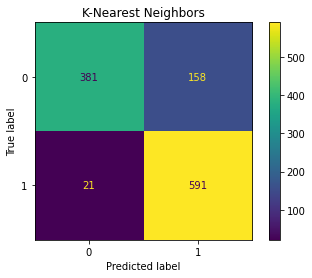

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("K-Nearest Neighbors")
ConfusionMatrixDisplay.from_estimator(knn, test_set, test_label, ax=ax)

In [ ]:
# Saving results
key = "knn"
outputs[key] = {}
outputs[key]["model_selection_time"] = knn_model_selection_time
outputs[key]["params"] = knn_best_params
outputs[key]["model"] = knn
outputs[key]["train_acc"] = acc_knn_train
outputs[key]["test_acc"] = acc_knn_test

print(outputs[key])

{'model_selection_time': 0, 'params': None, 'model': KNeighborsClassifier(leaf_size=45, n_neighbors=15, weights='distance'), 'train_acc': 0.9999034469440958, 'test_acc': 0.8444830582102519}


## K-NN using PCA for feature extraction

Using PCA we try to reduce the curse of dimensionality problem of alghoritms like K-NN

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def apply_PCA(n_components):
    pca = PCA(n_components=n_components)
    train_set_pca = pca.fit_transform(train_set)
    test_set_pca = pca.transform(test_set)
    return train_set_pca, test_set_pca

In [ ]:
def grid_search_knn_pca(train_set, train_label, n_components):
    param_dist = {"n_neighbors": [i for i in range(5,101,5)],
              "weights" : ['uniform', 'distance'],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [i for i in range(1, n_components+1)],
              'p': [1, 2],
              'metric': ['minkowski', 'cityblock']}

    knn = KNeighborsClassifier()

    start_time = time.time()
    
    gs = RandomizedSearchCV(knn, param_dist, cv=5, return_train_score=True)
    gs.fit(train_set, train_label)
    knn_best_params = gs.best_params_

    end_time = time.time()
    knn_model_selection_time = end_time-start_time
    print("Model selection time", knn_model_selection_time, "sec")

    n_neighbors = knn_best_params["n_neighbors"]
    weights = knn_best_params["weights"]
    algorithm = knn_best_params["algorithm"]
    leaf_size = knn_best_params["leaf_size"]
    p = knn_best_params["p"]
    metric = knn_best_params["metric"]
    return n_neighbors,weights,algorithm, p, metric, leaf_size

In [ ]:
knn_pca_result = {}

if compute_model_selection: 
  for i in range(4,22,4):
    print("==============\t[ n_components : "+str(i)+" ]\t=============")
    train_set_pca, test_set_pca = apply_PCA(n_components=i)

    n_neighbors, weights, algorithm, p, metric, leaf_size = grid_search_knn_pca(train_set_pca, train_label, i)

    knn = KNeighborsClassifier(n_neighbors= n_neighbors, weights= weights, algorithm = algorithm, p=p, metric=metric, leaf_size=leaf_size)
    knn = knn.fit(train_set_pca, train_label)

    train_pred_knn  = knn.predict(train_set_pca)
    test_pred_knn   = knn.predict(test_set_pca)

    acc_knn_train, acc_knn_test, _, _ = evaluation(train_label=train_label, 
                                        train_pred=train_pred_knn, 
                                        test_label=test_label, 
                                        test_pred=test_pred_knn)
    print("Accuracy obtained:", acc_knn_test)

    key = "n_components_"+str(i)
    knn_pca_result[key] = {}
    knn_pca_result[key]["acc"] = acc_knn_test
    knn_pca_result[key]["params"] = (n_neighbors, weights, algorithm, p, metric, leaf_size)
    knn_pca_result[key]["model"] = knn
    knn_pca_result[key]["test_set_pca"] = test_set_pca

In [ ]:
max_pca_acc = 0
best_knn_pca_params = None
best_pca_dim = 0
best_pca_knn_model = None
best_pca_test_set = None

if compute_model_selection: 
  
  for dim in knn_pca_result:
    current_acc = knn_pca_result[dim]["acc"]
    if current_acc>max_pca_acc:
      max_pca_acc = current_acc
      best_knn_pca_params = knn_pca_result[dim]["params"]
      best_pca_dim = dim
      best_pca_knn_model = knn_pca_result[dim]["model"]
      best_pca_test_set = knn_pca_result[dim]["test_set_pca"]
  print(max_pca_acc, best_knn_pca_params, best_pca_dim, best_pca_test_set) 

else: 
  n_components=20
  n_neighbors = 20
  weights = 'distance'
  algorithm = 'kd_tree'
  p = 2
  metric = 'cityblock' 
  leaf_size =8

In [ ]:
train_set_pca, test_set_pca = apply_PCA(n_components=n_components)
knn = KNeighborsClassifier(n_neighbors= n_neighbors, weights= weights, algorithm = algorithm, p=p, metric=metric, leaf_size=leaf_size)
knn = knn.fit(train_set_pca, train_label)

train_pred_knn  = knn.predict(train_set_pca)
test_pred_knn   = knn.predict(test_set_pca)

In [ ]:
acc_knn_train, acc_knn_test, f1_train, f1_test = evaluation(train_label=train_label, 
                                       train_pred=train_pred_knn, 
                                       test_label=test_label, 
                                       test_pred=test_pred_knn)
if not compute_model_selection:
  best_score = CrossValidate(knn, train_set=train_set_pca, train_label=train_label)

results_df = append_df(results_df, "KNN+PCA", acc_knn_test, f1_test, best_score)

Accuracy train set  0.9999034469440958
Accuracy test set  0.8444830582102519

Precision train set  0.9999034668355372
Recall train set  0.9999034469440958
F1 score train set  0.9999034475314841
Support train set  (array([0.99979398, 1.        ]), array([1.        , 0.99981831]), array([0.99989698, 0.99990915]), array([4853, 5504]))

Precision test set  0.8627471840376967
Recall test set  0.8444830582102519
F1 score test set  0.8410754970353064
Support test set  (array([0.94554455, 0.78982597]), array([0.70871985, 0.96405229]), array([0.81018028, 0.8682855 ]), array([539, 612]))
Cross Validation Score:  0.8403985726776649


In [ ]:
report_scores(train_label, train_pred_knn)

              precision    recall  f1-score   support

     Non-Bot       1.00      1.00      1.00      4853
         Bot       1.00      1.00      1.00      5504

    accuracy                           1.00     10357
   macro avg       1.00      1.00      1.00     10357
weighted avg       1.00      1.00      1.00     10357



In [ ]:
report_scores(test_label, test_pred_knn)

              precision    recall  f1-score   support

     Non-Bot       0.95      0.71      0.81       539
         Bot       0.79      0.96      0.87       612

    accuracy                           0.84      1151
   macro avg       0.87      0.84      0.84      1151
weighted avg       0.86      0.84      0.84      1151



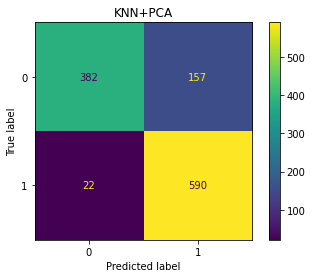

In [ ]:
plt.figure()
ax = plt.gca()
ax.set_title("KNN+PCA")
ConfusionMatrixDisplay.from_estimator(knn, test_set_pca, test_label, ax=ax)

In [ ]:
# Saving results
key = "knn_pca"
outputs[key] = {}
outputs[key]["params"] = best_knn_pca_params
outputs[key]["model"] = knn
outputs[key]["test_acc"] = acc_knn_test
outputs[key]["best_pca_dim"] = n_components
outputs[key]["best_pca_test_set"] = best_pca_test_set

print(outputs[key])

{'params': None, 'model': KNeighborsClassifier(algorithm='kd_tree', leaf_size=8, metric='cityblock',
                     n_neighbors=20, weights='distance'), 'test_acc': 0.8444830582102519, 'best_pca_dim': 20, 'best_pca_test_set': None}


## All Classifiers Ensable

In [ ]:
ensamble_tmp = np.zeros(len(test_label))
c = 0
for model in outputs:
  if outputs[model]['test_acc'] >= 0.84 and outputs[model]['model'] is not None:
    c += 1
    print(model)
    if model == 'knn_pca':
      ensamble_tmp += outputs[model]['model'].predict(test_set_pca) 
    else:
      ensamble_tmp += outputs[model]['model'].predict(test_set)
# Mean of all the models
ensamble_mean_test = np.zeros(len(test_label))
ensamble_mean_test = np.round(np.divide(ensamble_tmp, c))

dt
rf
nn
svc
gbc
bagging
AdaBoost+DT
AdaBoost+RF
knn
knn_pca


In [ ]:
report_scores(test_label, ensamble_mean_test)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.87      1151
   macro avg       0.90      0.86      0.86      1151
weighted avg       0.89      0.87      0.86      1151



In [ ]:
f1_test = metrics.f1_score(test_label, ensamble_mean_test, average='weighted')
acc_ens_test = metrics.accuracy_score(test_label, ensamble_mean_test)

results_df = append_df(results_df, "ENSAMBLE", acc_ens_test, f1_test, None)

In [ ]:
key = "ens"
outputs[key] = {'model': None,
                'test_acc': acc_ens_test,
                'test_pred': ensamble_mean_test,
                'model_selection_time': None,
                'params': 'mean'}

# Results

In [ ]:
test_accuracies = []
models = []

for model in outputs:
  test_accuracies.append(outputs[model]["test_acc"])
  models.append(model)
  print(model,outputs[model]["test_acc"])

best_model = models[np.argmax(test_accuracies)]
print()
print("Our best classifier is *",best_model, 
      "* with an accuracy of",round(np.max(test_accuracies),6)*100, "% on test set.")

dt 0.8653344917463076
rf 0.8653344917463076
nb 0.8218940052128584
nn 0.8627280625543006
svc 0.8653344917463076
gbc 0.8566463944396178
bagging 0.8601216333622936
AdaBoost+DT 0.8653344917463076
AdaBoost+RF 0.8653344917463076
knn 0.8444830582102519
knn_pca 0.8444830582102519
ens 0.8653344917463076

Our best classifier is * dt * with an accuracy of 86.5334 % on test set.


In [ ]:
outputs[best_model]

{'model_selection_time': None,
 'params': None,
 'model': DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=14,
                        max_features=26, min_samples_leaf=100,
                        min_samples_split=50),
 'train_acc': 0.8605773872743072,
 'test_acc': 0.8653344917463076}

In [ ]:
if best_model == "knn_pca":
    test_set = outputs[best_model]["best_pca_test_set"]

In [ ]:
model = outputs[best_model]["model"]

test_set_predicted = model.predict(test_set)

In [ ]:
print("On the test set, we obtain an accuracy of", round(metrics.accuracy_score(test_label, test_set_predicted),6)*100,"%")

On the test set, we obtain an accuracy of 86.5334 %


In [ ]:
report_scores(test_label, test_set_predicted)

              precision    recall  f1-score   support

     Non-Bot       1.00      0.71      0.83       539
         Bot       0.80      1.00      0.89       612

    accuracy                           0.87      1151
   macro avg       0.90      0.86      0.86      1151
weighted avg       0.89      0.87      0.86      1151



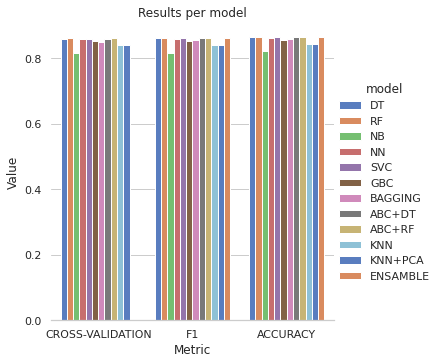

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x='score', y="value", hue="model", data=results_df, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Value")
g.set_xlabels("Metric")
g.set(title='Results per model')

## Plotting results with PCA


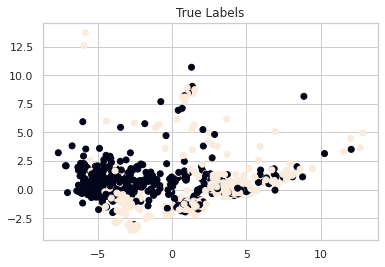

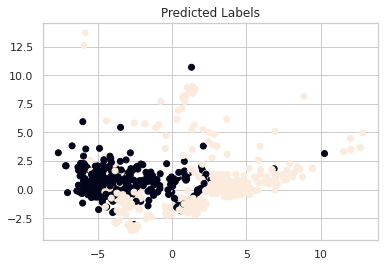

In [ ]:
pca = PCA(n_components=2)

test_set_plot = pca.fit_transform(test_set)
plt.scatter(test_set_plot[:, 0], test_set_plot[:, 1], c=test_label);
plt.title("True Labels")
plt.show()

plt.scatter(test_set_plot[:, 0], test_set_plot[:, 1], c=test_set_predicted);
plt.title("Predicted Labels")
plt.show()

## ROC Curve

In [ ]:
from sklearn.metrics import RocCurveDisplay

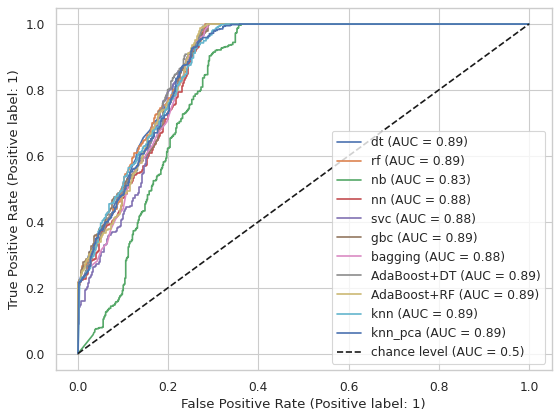

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()

for key, value in outputs.items():
  model = outputs[key]["model"]
  if model is None:
    continue
  if key == "knn_pca":
    RocCurveDisplay.from_estimator(model, test_set_pca, test_label, name=key, ax=ax)
  else:
    RocCurveDisplay.from_estimator(model, test_set, test_label, name=key,ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend()
plt.show()